# 23일차(2025.07.27)


## 개요
- 모델 검증 기법 (KFold 활용)

데이터셋 생성

In [3]:
import pandas as pd
import numpy as np

np.random.seed(42)

n = 200
df = pd.DataFrame({
    '수면시간': np.random.normal(9, 1, n).round(1),  # 평균 7시간, 표준편차 1
    'SNS사용시간': np.random.normal(6, 0.8, n).round(1),
    '하루공부시간': np.random.normal(8, 1, n).round(1),
    '아침식사빈도': np.random.randint(0, 8, n),
    '중간': np.random.randint(50, 100, n),
    '기말': np.random.randint(50, 100, n),
    '과제': np.random.randint(50, 100, n)
})

# 총점 계산
df['총점'] = (df['중간'] * 0.3 + df['기말'] * 0.4 + df['과제'] * 0.3).round(1)

### 1. Train/test split평가
- 입력 변수 : `수면시간`, `SNS사용시간`, `하루공부시간`, `아침식사빈도`

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.model_selection import train_test_split
x=df[['수면시간', 'SNS사용시간', '하루공부시간', '아침식사빈도']]
y=df['총점']

x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.2, random_state=42)

model=LinearRegression()
model.fit(x_train, y_train)
y_pred=model.predict(x_test)

In [5]:
# 성능 평가
def linear_evaluate(df):
    mse=mean_squared_error(y_test, y_pred)
    rmse=np.sqrt(mse)
    r2=r2_score(y_test, y_pred)
    print('RMSE :', rmse)
    print('R2 :', r2)
linear_evaluate(df)

RMSE : 8.631141221546462
R2 : -0.022153952143565858


- 해석 : 모델의 설명력이 매우 떨어진다. 쓸만한 모델이 되지 못한다.
- 이유 : 랜덤으로 생성한 데이터 셋이므로 변수간의 상관관계가 매우 떨여졌을 것이다

### 2. 예측값 vs 실제값 시각화
- 산점도를 그려서 예측이 얼마나 벗어났는지 확인한다.

C:\Users\kgh44\AppData\Local\Temp\ipykernel_1608\3237725231.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='red')


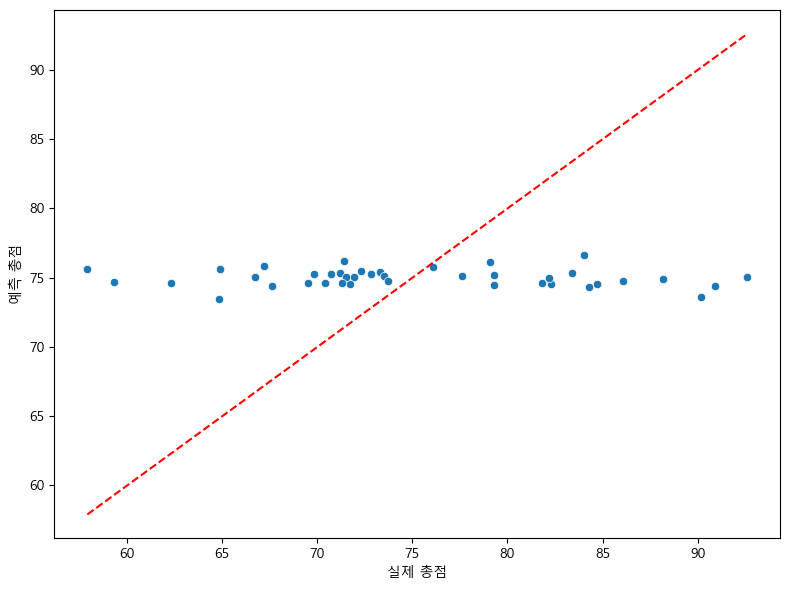

In [8]:
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', family='Malgun Gothic')

def linear_visual(df):
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='red')
    plt.xlabel('실제 총점')
    plt.ylabel('예측 총점')
    plt.tight_layout()
    plt.show()
linear_visual(df)

- y=x 축 기준으로, 점들이 매우 퍼져있다. 정확도가 매우 떨어짐을 알 수 있다.

### 3. K-Fold 검증

- `cross_val_score()`로 5개 Fold에서 평균 성능 측정

In [6]:
kfold=KFold(n_splits=5, shuffle=True, random_state=42)

neg_mse_scores = cross_val_score(model, x, y, cv=kfold, scoring='neg_mean_squared_error')
rmse_score=np.sqrt(-neg_mse_scores)

print('평균 RMSE :', rmse_score.mean())

평균 RMSE : 8.012105736052328


- KFold별 RMSE 시각화

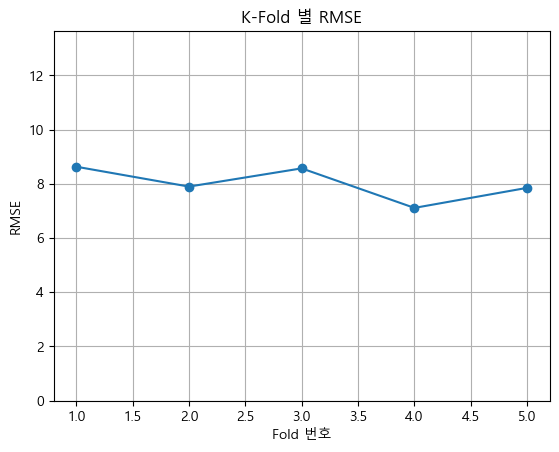

In [9]:
plt.plot(range(1, 6), rmse_score, marker='o')
plt.title("K-Fold 별 RMSE")
plt.xlabel("Fold 번호")
plt.ylabel("RMSE")
plt.ylim(0, max(rmse_score) + 5)
plt.grid(True)
plt.show()

### 4. 상관 분석을 통한 원인 규명

In [10]:
df.corr(numeric_only=True)['총점'].sort_values(ascending=False)

총점         1.000000
기말         0.713578
중간         0.459584
과제         0.441975
하루공부시간     0.052401
아침식사빈도     0.026412
SNS사용시간    0.021847
수면시간       0.013037
Name: 총점, dtype: float64

- 해석 : 모델에 쓰인 변수들이 모두 총점과 상관 관계가 거의 없다. 때문에 모델의 예측이 매우 떨어졌을 가능성이 크다